In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

# Monte-Carlo Approximation of VPI and myopic VOC 
This notebook demonstrates that VPI and myopic VOC can be approximated with reasonable accuracy
and efficiency via sampling.

## VOC

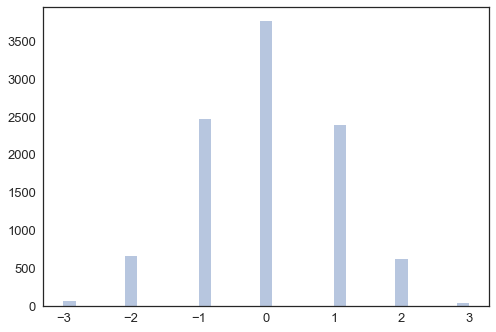

In [51]:
from scipy.stats import norm

def reward(n=7):
    d = norm(0, 1)
    vals = np.linspace(-3, 3, n)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    return Categorical(vals, probs)

sns.distplot(reward().sample(10000), kde=0)

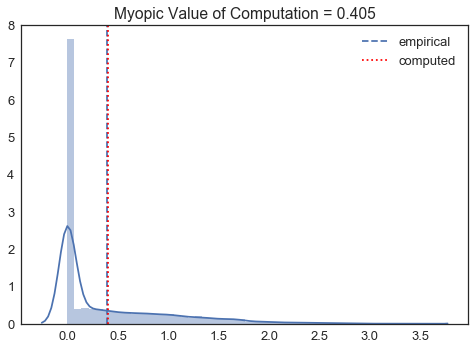

In [11]:
agent = Agent()
env = MouselabEnv([4,1,2], reward=reward(), cost=0, expand_only=True)
agent.register(env)
agent.register(FixedPlanPolicy([1, env.term_action]))
voc_computed = env.myopic_voc(1, env.init)
voc_empirical = np.array(agent.run_many(10000)['return'])
sns.distplot(voc_empirical)
plt.axvline(np.mean(voc_empirical), ls='--', label='empirical')
plt.axvline(voc_computed, ls=':', c='r', label='computed')
plt.title('Myopic Value of Computation = {:.3f}'.format(voc_computed))
plt.legend()

In [22]:
%%time
# How efficient and reliable (low variance) is the approximation?
assert 0, 'this is wrong because caching'
env.reset()
samples = [env.myopic_voc(1, env.init) for _ in range(100)]
sns.distplot(samples, color='r')
plt.title('Approximately {}'.format(Normal.fit(samples)))

AssertionError: this is wrong because caching

## VPI


VPI time: 0.12699129799875664


/usr/local/lib/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


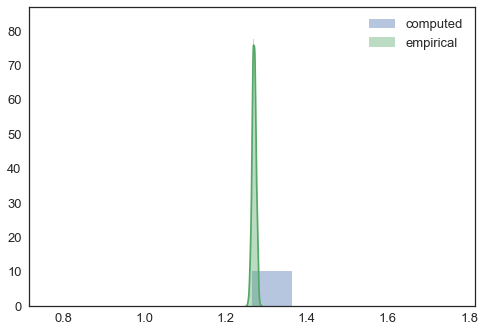

In [162]:
env = MouselabEnv(2,2, reward=Normal(0, 1), n_sample=5000, cost=0, expand_only=True)

def empirical_vpi(env, n=5000):
    agent = Agent()
    agent.register(env)
    agent.register(FixedPlanPolicy(range(1, env.term_action + 1)))
    return pd.Series(agent.run_many(n)['return'])

from mouselab import *
def computed_vpi(env, n=100):
    for i in range(n):
        flat_node_value_after_observe.cache_clear()
        env.vpi.cache_clear()
        yield env.vpi(env.init)

vpi_emp = empirical_vpi(env)
from contexttimer import Timer
with Timer() as t:
    vc = list(computed_vpi(env))
print('VPI time:', t.elapsed)
ve = [vpi_emp.sample(50000, replace=True).mean() for _ in range(1000)]
sns.distplot(vc, label='computed')
sns.distplot(ve, label='empirical')
plt.legend()
# plt.xlim(1.25, 1.35)

In [2]:
from distributions import *
from policies import *
from mouselab import *

env.vpi.cache_clear()
flat_node_value_after_observe.cache_clear()
env = MouselabEnv(2, 7, reward=Normal(0, 1), n_sample=10000, cost=0, expand_only=True)
pol = LiederPolicy([1,1,0,1,1])
agent = Agent()
agent.register(pol)
agent.register(env)
# agent.run_many(100)
%prun print('Lieder:', pd.DataFrame(agent.run_many(4))['return'].mean())
print('VPI computed:', env.vpi(env.init))
print('VPI empirical:', empirical_vpi(env, 1000).mean())

NameError: name 'env' is not defined

4 nodes in frontier


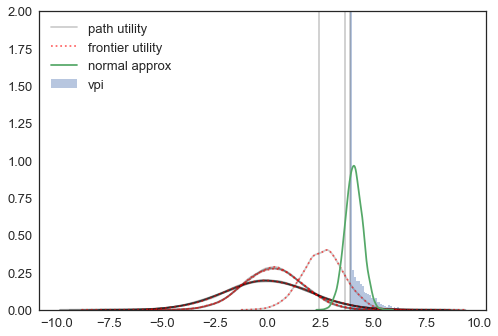

In [7]:
from distributions import *
from policies import *
from mouselab import *
from universal_divergence import estimate as divergence

def vpn(env, node, state):
    obs = env.subtree[node][1:]
    return (env.node_value_after_observe(obs, node, state))

env = MouselabEnv(2, 4, reward=Normal(0, 1), n_sample=500, cost=0, expand_only=True)
agent = Agent()
agent.register(env)
agent.register(LiederPolicy([1,1,1,1,1]))
tr = agent.run_episode()

env.reset()
state = env._state
state = tr['states'][8]

def plot_quality(nodes, label, c, alpha, ls):
    lst = []
    lab = -1
    for n in nodes:
        d = env.node_quality(n, state)
        if len(d._samples) == 1:
            plt.axvline(d._samples[0], c=c, ls=ls, alpha=alpha)
        else:
            if lab == -1:
                lab = label
            sns.distplot(d._samples, color=c,
                         hist=0, kde_kws=dict(alpha=alpha, ls=ls), label=lab)
            lab = None
        lst.append(d)
    return lst
    
paths = plot_quality(env.leaves(), 'path utility', 'k', 0.2, '-')
frontier = plot_quality(env.frontier(state), 'frontier utility', 'r', 0.6, ':')
print(len(frontier), 'nodes in frontier')


x = vpn(env, 0, state)
sns.distplot(x._samples, label='vpi', kde=0, norm_hist=True)
xhat = x.to_normal().sample(len(x._samples))
sns.distplot(xhat, label='normal approx', hist=0)
plt.legend()
plt.ylim(0,2)
None

In [14]:
state

(0,
 SD(696),
 SD(920),
 SD(136),
 SD(192),
 SD(416),
 SD(408),
 SD(464),
 SD(912),
 SD(952),
 SD(64),
 SD(232),
 SD(8),
 SD(448),
 SD(504))

10000

In [43]:
xhat.shape, x._samples.shape

((10000,), (10000,))

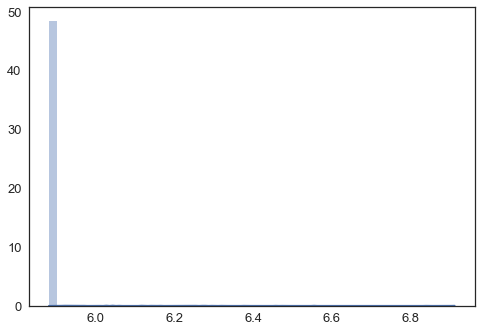

In [68]:
sns.distplot(x._samples)

TypeError: len() of unsized object

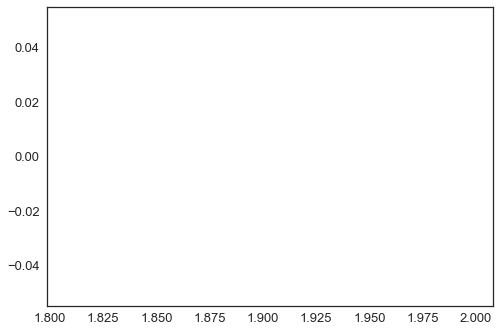

In [155]:
sns.distplot(frontier[2]._samples)

In [145]:
env.node_quality(np.argmax(frontier), state)._samples.mean()w

0.36322566213391799

In [50]:
xhat

array([ 2.258,  2.5  ,  2.93 , ...,  1.969,  1.282,  1.794])

flat_node_value_after_observe ((SD(960),),) {} -> Categorical(vals=[0], probs=[1])
smax (SD(720), SD(720))
flat_node_value_after_observe ((SD(960), SD(960), SD(960)),) {} -> SD(664)
smax (SD(904), SD(904))
flat_node_value_after_observe ((SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960)),) {} -> SD(480)
smax (SD(208), SD(208))
flat_node_value_after_observe ((0.0, SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960), SD(960)),) {} -> SD(88)


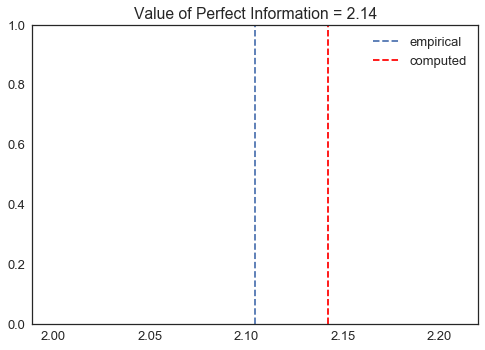

In [16]:
env = MouselabEnv(2,3, reward=Normal(0, 1), n_sample=10000, cost=0, expand_only=True)
agent = Agent()
env.reset()
agent.register(env)
agent.register(FixedPlanPolicy(range(1, env.term_action + 1)))
vpi_computed = env.vpi(env.init)
# vpi_empirical = agent.run_many(100000)['return']
# sns.distplot(vpi_empirical)
plt.axvline(np.mean(vpi_empirical), ls='--', label='empirical')
plt.axvline(vpi_computed, ls='--', c='r', label='computed')
plt.title('Value of Perfect Information = {:.2f}'.format(vpi_computed))
plt.legend()

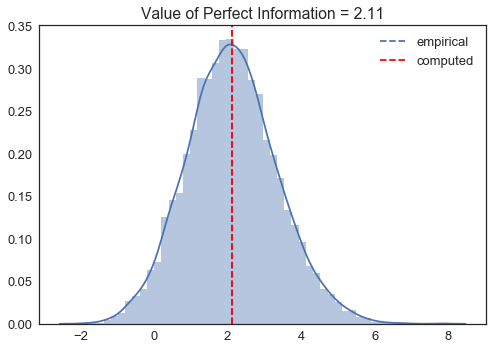

In [23]:
env = MouselabEnv(2,3, reward=Normal(0, 1), n_sample=10000, cost=0, expand_only=True)
agent = Agent()
env.reset()
agent.register(env)
agent.register(FixedPlanPolicy(range(1, env.term_action + 1)))
vpi_computed = env.vpi(env.init)
# vpi_empirical = agent.run_many(10000)['return']
np.mean(vpi_empirical)
sns.distplot(vpi_empirical)
plt.axvline(np.mean(vpi_empirical), ls='--', label='empirical')
plt.axvline(vpi_computed, ls='--', c='r', label='computed')
plt.title('Value of Perfect Information = {:.2f}'.format(vpi_computed))
plt.legend()

CPU times: user 5.61 s, sys: 39.7 ms, total: 5.65 s
Wall time: 5.79 s


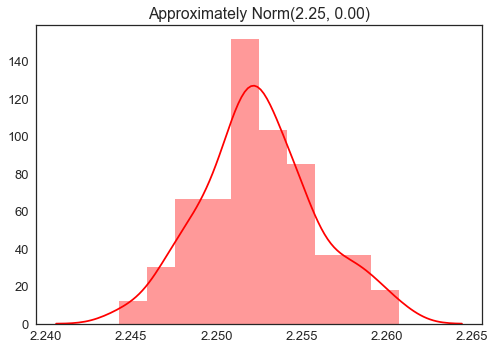

In [87]:
%%time
# How efficient and reliable (low variance) is the approximation?
env.reset()
samples = [env.vpi() for _ in range(100)]
sns.distplot(samples, color='r', label='computed')
plt.title('Approximately {}'.format(Normal.fit(samples)))

## VPI action

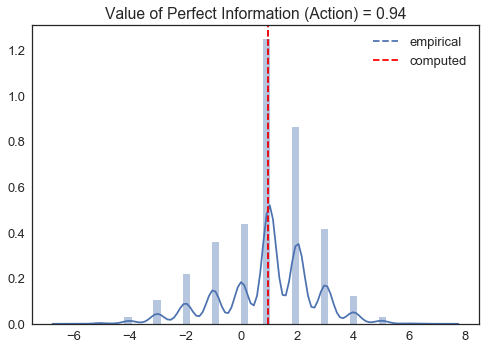

In [176]:
env.reset()
agent.register(FixedPlanPolicy([1,2,3,4,env.term_action]))
vpi_computed = env.node_value_after_observe([1,2,3,4], 0).expectation()
vpi_empirical = agent.run_many(10000)['return']
sns.distplot(vpi_empirical)
plt.axvline(np.mean(vpi_empirical), ls='--', label='empirical')
plt.axvline(vpi_computed, ls='--', c='r', label='computed')
plt.title('Value of Perfect Information (Action) = {:.2f}'.format(vpi_computed))
plt.legend()

## How does it work?
All values are represented as `Distribution` objects, defined in the `distributions.py`.
The `dmax` function returns the distribution of the maximum of two distributions. In the
implementation, this defines a generative model that we can sample from. Given this handy
function, we can write a recursive function that returns a distribution over the expecte value
of a node, given that some number of nodes have been observed. To do this, we take the maximum
of the expectation for unobserved nodes, and the distribution of the maximum for the
nodes to be observed.

```python
    def node_value_after_observe(self, obs, node, state=None):
        """A distribution over the expected value of node, after making an observation.
        
        obs can be a single node, a list of nodes, or 'all'
        """
        state = state if state is not None else self._state

        def r(n):
            if obs == 'all' or n in obs:
                return state[n]  # a distribution or a previously observed value
            else:
                return expectation(state[n])

        return dmax((self.node_value_after_observe(obs, n1, state) + r(n1)
                     for n1 in self.tree[node]),
                    default=PointMass(0))
```

VPI and myopic VOC are straightforward to define given this function; see `meta.py`. 
The plot below shows the value of observing various numbers of nodes. Note that
this is *not* non-myopic VOC because it assumes that all observations are made at once,
while non-myopic VOC determines the second computation based on the outcome of the first.

GenerativeModel for observing all 4:
dmax(add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)))


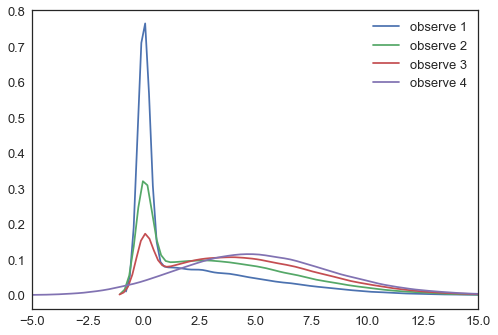

In [6]:
env.reset()
first_four = env.tree[0]
for i in range(1, 5):
    val = env.node_value_after_observe(first_four[:i], 0,)
    sns.distplot(val.sample(100000), hist=0, label='observe {}'.format(i))

plt.xlim(-5, 15)
print('GenerativeModel for observing all 4:\n{}'.format(val))

In [ ]:
# This cell intentionally left blank.
























In [322]:
env = MouselabEnv([4,1,2], reward=reward(100), cost=0)
print('VOC_1: {:.4f}'.format(env.myopic_voc(1)))
print('VPI_full: {:.2f}'.format(env.vpi()))
print('VPI_action: {:.2f}'.format(env.node_value_after_observe([1,2,3,4], 0).expectation()))

def data():
    for n in range(3, 50, 2):
        env = MouselabEnv([4,1,2], reward=reward(n), cost=0)
        yield {
            'VOC_1': env.myopic_voc(1),
            'VPI_full': env.vpi(),
            'VPI_action': env.node_value_after_observe([1,2,3,4], 0).expectation(),
        }
df = pd.DataFrame(data())
df.plot()
plt.xlabel('number of outcomes')
plt.title('Effect of discretization on feature values')

VOC_1: 0.3983
VPI_full: 2.23
VPI_action: 2.37


In [63]:
env = MouselabEnv([2, 2], reward=Categorical([0,1]), cost=0)
def tree(env, s=0):
    return [env._state[s], [tree(env, s1) for s1 in env.tree[s]]]

tree(env)

[0, [[Cat, [[Cat, []], [Cat, []]]], [Cat, [[Cat, []], [Cat, []]]]]]